# Machine Learning

In [1]:
import numpy as np
import pandas as pd
import pickle
from difflib import get_close_matches

import random

import dgl.function as fn
from dgl import DGLGraph

import time

import torch
import torch.nn as nn
import torch.nn.functional as F

Loading the similarity matrices and the dataframe

In [2]:
Data_path = 'Data/'

sim_mat = {}
names = ['keywords', 'genre', 'crew', 'cast']
for name in names:
    with open(Data_path+'csim_'+name, 'rb') as src:
        sim_mat[name] = pickle.load(src)
        print(f'>>> Loading {name} similarity matrix with shape {sim_mat[name].shape}')

>>> Loading keywords similarity matrix with shape (4803, 4803)
>>> Loading genre similarity matrix with shape (4803, 4803)
>>> Loading crew similarity matrix with shape (4803, 4803)
>>> Loading cast similarity matrix with shape (4803, 4803)


**Alternative 1** Combine the 4 similarity matrices equitably (**to be optimized**) and pruned those with a similarity below 0.25

In [3]:
# Simple way
adj_mat = sim_mat['keywords'].copy()
for name in names[1:]:
    adj_mat = adj_mat.add(sim_mat[name], fill_value=0)
adj_mat = adj_mat/4    

threshold = 0.25
adj_mat[adj_mat < threshold] = 0
#weight_dict = {'names':names, 'weights':[0.25, 0.25, 0.25, 0.25]}

In [109]:
features = ['budget','popularity','revenue','vote_average','vote_count']

IMDB_path = Data_path + 'tmdb_5000_movies.csv'
IMDB = pd.read_csv(IMDB_path)
IMDB.set_index('original_title',inplace=True)
IMDB_feat = IMDB[['id'] + features]

In [5]:
oscars_path = Data_path + 'oscars_website.csv'
oscars = pd.read_csv(oscars_path).drop(columns='Unnamed: 0').set_index('Films')
oscar_movies = list(oscars.index)

IMDB_movies = list(IMDB.index)

oscar_labels = pd.DataFrame(index=IMDB_movies, columns=['Nominations', 'Oscars'], dtype='int64')

cutoff = 0.90
for title in IMDB_movies:
    match = get_close_matches(title, oscar_movies, n=1, cutoff=cutoff)
    if(match):
        if(title != match[0]):
            print(title, match[0])
        if(oscars['Nominations'][match[0]].size > 1):
            oscar_labels['Nominations'][title] = oscars['Nominations'][match[0]].iloc[0]
            oscar_labels['Oscars'][title] = oscars['Oscars'][match[0]].iloc[0]
        else:
            oscar_labels['Nominations'][title] = oscars['Nominations'][match[0]]
            oscar_labels['Oscars'][title] = oscars['Oscars'][match[0]]
    else:
        oscar_labels['Nominations'][title] = 0
        oscar_labels['Oscars'][title] = 0

Spider-Man 3 Spider-Man 2
Men in Black 3 Men in Black
The Lovers The Lover
Kung Fu Panda 3 Kung Fu Panda 2
Lethal Weapon 4 Lethal Weapon 2
Stuart Little 2 Stuart Little
Star Wars: Episode III - Revenge of the Sith Star Wars: Episode III Revenge of the Sith
Star Wars: Episode II - Attack of the Clones Star Wars Episode II Attack of the Clones
Star Wars: Episode I - The Phantom Menace Star Wars Episode I: The Phantom Menace
Flight of the Phoenix The Flight of the Phoenix
Driven Drive
Basic Instinct 2 Basic Instinct
Despicable Me Despicable Me 2
Man on Fire Man on Wire
Up Close & Personal Up Close and Personal
DragonHeart Dragonheart
Alien³ Alien
The Godfather: Part III The Godfather, Part III
Moulin Rouge! Moulin Rouge
Beverly Hills Cop III Beverly Hills Cop II
Boomerang Boomerang!
Here Comes the Boom Here Comes the Groom
Red Riding Hood Redux Riding Hood
Back to the Future Part III Back to the Future Part II
Shall We Dance? Shall We Dance
The Count of Monte Cristo The Son of Monte Crist

In [115]:
# Generate graph
G = DGLGraph(graph_data=adj_mat.values)

tensor_feat = torch.FloatTensor(IMDB_feat.values[:,1:])
tensor_labels_nom = torch.FloatTensor(oscar_labels.values[:,0])
tensor_labels_osc = torch.FloatTensor(oscar_labels.values[:,0])

probs = np.zeros(adj_mat.shape[0])
for i in range(adj_mat.shape[0]):
    if(random.random() < 0.8):
        if(random.random() > 0.8):
            probs[i] = 1
    else:
        probs[i] = 2

train_mask = torch.BoolTensor(probs == 0)
val_mask = torch.BoolTensor(probs == 1)
test_mask = torch.BoolTensor(probs == 2)

In [116]:
class LaplacianPolynomial(nn.Module):
    def __init__(self,
                 in_feats: int,
                 out_feats: int,
                 k: int,
                 dropout_prob: float,
                 norm=True):
        super().__init__()
        self._in_feats = in_feats
        self._out_feats = out_feats
        self._k = k
        self._norm = norm
        # Contains the weights learned by the Laplacian polynomial
        self.pol_weights = nn.Parameter(torch.Tensor(self._k + 1))
        # Contains the weights learned by the logistic regression (without bias)
        self.logr_weights = nn.Parameter(torch.Tensor(in_feats, out_feats))
        self.dropout = nn.Dropout(p=dropout_prob)
        self.reset_parameters()

    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        torch.manual_seed(0)
        torch.nn.init.xavier_uniform_(self.logr_weights, gain=0.01)
        torch.nn.init.normal_(self.pol_weights, mean=0.0, std=1e-3)

    def forward(self, graph, feat):
        r"""Compute graph convolution.

        Notes
        -----
        * Input shape: :math:`(N, *, \text{in_feats})` where * means any number of additional
          dimensions, :math:`N` is the number of nodes.
        * Output shape: :math:`(N, *, \text{out_feats})` where all but the last dimension are
          the same shape as the input.

        Parameters
        ----------
        graph (DGLGraph) : The graph.
        feat (torch.Tensor): The input feature

        Returns
        -------
        (torch.Tensor) The output feature
        """
        feat = self.dropout(feat)
        graph = graph.local_var()
        
        # D^(-1/2)
        norm = torch.pow(graph.in_degrees().float().clamp(min=1), -0.5)
        shp = norm.shape + (1,) * (feat.dim() - 1)
        norm = torch.reshape(norm, shp)
        
        # mult W first to reduce the feature size for aggregation.
        feat = torch.matmul(feat, self.logr_weights) # X*Teta

        result = self.pol_weights[0] * feat.clone() # a0*L^0*X*Teta <-- fisrt polynomial weight a0 * L^0 * x

        for i in range(1, self._k + 1): # get the next polynomial coefficient (a1*L^1, a2*L^2, ..... ak*L^k) 
            old_feat = feat.clone()
            if self._norm:
                feat = feat * norm
            graph.ndata['h'] = feat
            # Feat is not modified in place
            graph.update_all(fn.copy_src(src='h', out='m'),
                             fn.sum(msg='m', out='h')) # update all nodes with msg function copy_src (get data from source node) and reduce function sum
            if self._norm:
                graph.ndata['h'] = graph.ndata['h'] * norm

            feat = old_feat - graph.ndata['h']
            result += self.pol_weights[i] * feat

        return result

    def extra_repr(self):
        """Set the extra representation of the module,
        which will come into effect when printing the model.
        """
        summary = 'in={_in_feats}, out={_out_feats}'
        summary += ', normalization={_norm}'
        return summary.format(**self.__dict__)

Once we have are model ready we just need to create a function that performs one step of our training loop, and another one that evaluates our model.

In [196]:
def train(model, g, features, labels, loss_fcn, train_mask, optimizer):
    model.train()  # Activate dropout
    
    logits = model(g, features) # prediction
    #print(logits[train_mask].grad, labels[train_mask])
    loss = loss_fcn(logits[train_mask], labels[train_mask])
    #print(loss)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss

def evaluate(model, g, features, labels, mask):
    model.eval()  # Deactivate dropout
    with torch.no_grad():
        logits = model(g, features)[mask]  # only compute the evaluation set
        labels = labels[mask]
        correct = torch.sum((logits.round() == labels).diagonal())
        return correct.item() * 1.0 / len(labels)

Choose the training parameters.

In [225]:
in_feats = len(features)
output = 1
pol_order = 1
lr = 0.2
weight_decay = 5e-6
n_epochs = 500
p_dropout = 0

And train the classifier end to end.

In [226]:
model = LaplacianPolynomial(in_feats, output, pol_order, p_dropout)

loss_fcn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=lr,
                             weight_decay=weight_decay)

dur = []
for epoch in range(n_epochs):
    if epoch >= 3:
        t0 = time.time()
    loss = train(model, G, tensor_feat, tensor_labels_nom, loss_fcn, train_mask, optimizer)
    if epoch >= 3:
        dur.append(time.time() - t0)
        
    acc = evaluate(model, G, tensor_feat, tensor_labels_nom, val_mask)
    
    if epoch%10 == 0:
        print("Epoch {:05d} | Time(s) {:.4f} | Train Loss {:.4f} | Val Accuracy {:.4%}". format(
                epoch+1, np.mean(dur), loss.item(), acc))

print()
acc = evaluate(model, G, tensor_feat, tensor_labels_nom, test_mask)
print("Test Accuracy {:.4%}".format(acc))

Epoch 00001 | Time(s) nan | Train Loss 715298.2500 | Val Accuracy 5.1881%
Epoch 00011 | Time(s) 0.0410 | Train Loss 1495178805248.0000 | Val Accuracy 12.3217%
Epoch 00021 | Time(s) 0.0398 | Train Loss 1600171147264.0000 | Val Accuracy 18.5473%
Epoch 00031 | Time(s) 0.0385 | Train Loss 1038398914560.0000 | Val Accuracy 16.7315%
Epoch 00041 | Time(s) 0.0383 | Train Loss 409190170624.0000 | Val Accuracy 18.4176%
Epoch 00051 | Time(s) 0.0383 | Train Loss 72053522432.0000 | Val Accuracy 19.0661%
Epoch 00061 | Time(s) 0.0381 | Train Loss 3492669440.0000 | Val Accuracy 19.1958%
Epoch 00071 | Time(s) 0.0382 | Train Loss 214009984.0000 | Val Accuracy 19.3256%
Epoch 00081 | Time(s) 0.0383 | Train Loss 245349408.0000 | Val Accuracy 19.3256%
Epoch 00091 | Time(s) 0.0382 | Train Loss 109456392.0000 | Val Accuracy 19.3256%
Epoch 00101 | Time(s) 0.0383 | Train Loss 42983272.0000 | Val Accuracy 19.8444%
Epoch 00111 | Time(s) 0.0381 | Train Loss 16827550.0000 | Val Accuracy 19.3256%
Epoch 00121 | Time(

In [221]:
a = (model(G, tensor_feat)[train_mask]).round()

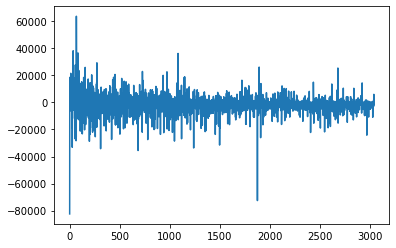

In [222]:
import matplotlib.pyplot as plt

plt.plot(a.detach())